In [1]:
# import sys
import numpy as np
import pathlib
import sys

import petsc4py
petsc4py.init(sys.argv)
import dolfin as dl
import hippylib as hl

dl.parameters["form_compiler"]["optimize"]     = True
dl.parameters["form_compiler"]["cpp_optimize"] = True
dl.parameters["form_compiler"]["representation"] = "uflacs"
dl.parameters["form_compiler"]["cpp_optimize_flags"] = "-O3 -ffast-math -march=native"

# for plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=4, rc={"lines.linewidth": 4})
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.unicode_minus'] = False

mpl.rcParams['text.usetex'] = True
# mpl.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}", r"\usepackage{amssymb}"]

# Quasistatic problem

In [2]:
# import
from PDE_model_help import GenericReprBase, FwdModelSource, FwdBoundary
from PDE_model_help import Misfit, FullTracer
from PDE_model_help import plot_prior, run_and_compare_approximations
from PDE_model import PDEModel

STATE = 0
PARAMETER = 1

In [3]:
# run_dir = 'test/'
# theta0 = [0.25]
# use_approx = True
# which_est = 0
# noise_variance = np.power(0.01, 2)

# num_samples = 5000
# pcn_s = 0.2
# p_mode = np.array([0.5, 10.])
# p_sigma = np.array([0.4, 0.4])

# out_path = run_dir

# mcmc_path = run_dir # results in chain_<id> folder

In [4]:
run_dir = 'run_1/'
theta0 = [0.25]
use_approx = True
which_est = 0
noise_variance = np.power(0.01, 2)

num_samples = 5000
pcn_s = 0.2
p_mode = np.array([0.5, 10.])
p_sigma = np.array([0.4, 0.4])

out_path = run_dir

mcmc_path = run_dir # results in chain_<id> folder

In [5]:
# run_dir = 'run_2/'
# theta0 = [0.25]
# use_approx = False
# which_est = 0
# noise_variance = np.power(0.01, 2)

# num_samples = 5000
# pcn_s = 0.2
# p_mode = np.array([0.5, 10.])
# p_sigma = np.array([0.4, 0.4])

# out_path = run_dir

# mcmc_path = run_dir # results in chain_<id> folder

In [6]:
# run_dir = 'run_3/'
# theta0 = [0.25]
# use_approx = True
# which_est = 1
# noise_variance = np.power(0.01, 2)

# num_samples = 5000
# pcn_s = 0.2
# p_mode = np.array([0.5, 10.])
# p_sigma = np.array([0.4, 0.4])

# out_path = run_dir

# mcmc_path = run_dir # results in chain_<id> folder

In [7]:
# run_dir = 'run_4/'
# theta0 = [0.25]
# use_approx = True
# which_est = 0
# noise_variance = np.power(0.001, 2)

# num_samples = 5000
# pcn_s = 0.2
# p_mode = np.array([0.5, 10.])
# p_sigma = np.array([0.4, 0.4])

# out_path = run_dir

# mcmc_path = run_dir # results in chain_<id> folder

# Create prior

In [8]:
# mcmc chains
chain_ids = [i+1 for i in range(4)]
mcmc_paths_chain = [mcmc_path + 'chain_%d/' % (i) for i in chain_ids]
mcmc_plot_path = mcmc_path
out_path_chain = out_path + 'plot/'
mcmc_paths_chain

['run_1/chain_1/', 'run_1/chain_2/', 'run_1/chain_3/', 'run_1/chain_4/']

/home/prashant/Dropbox/Work/Simulations/python_works/GoalOrientedModelCalibration/Quasistatic_Problem/PDE_model_help.py:240: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(samples[:, idx], hist=False, norm_hist = True, ax=axs[row, col])
/home/prashant/Dropbox/Work/Simulations/python_works/GoalOrientedModelCalibration/Quasistatic_Problem/PDE_model_help.py:263: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to upd

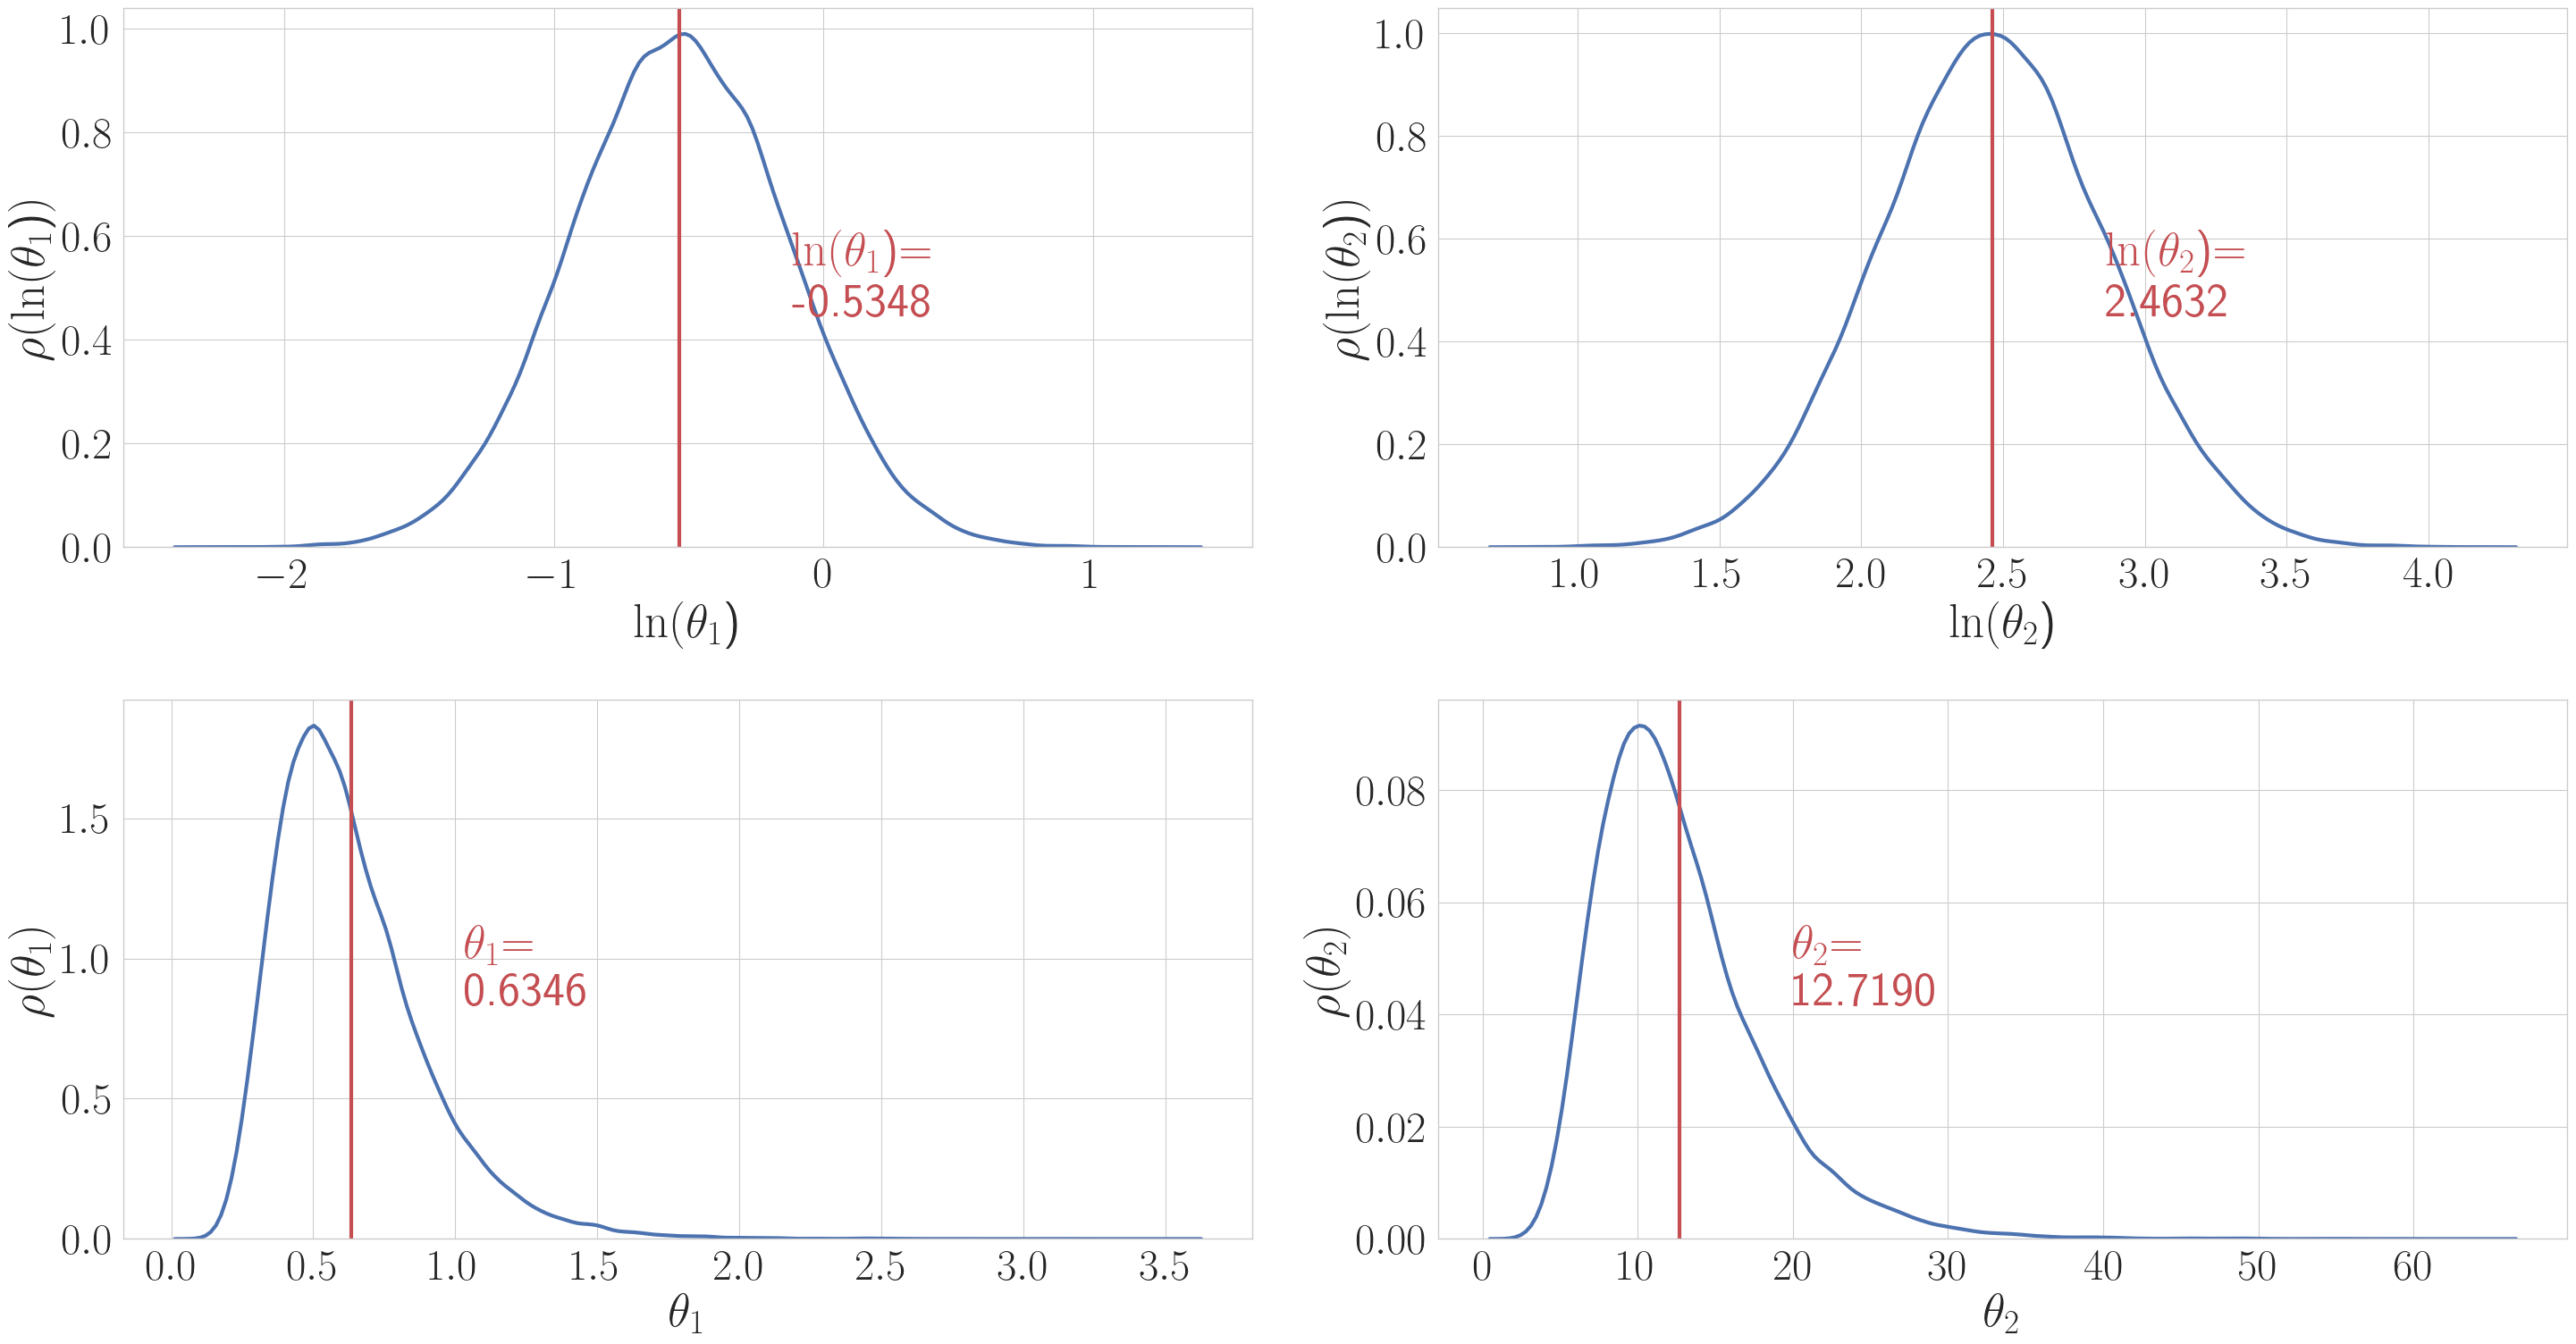

In [9]:
# load mesh
mesh = dl.RectangleMesh(dl.Point(0, 0), dl.Point(1,1), 50, 50)

# FE space
FE_polynomial = 1
Vu = dl.FunctionSpace(mesh, "Lagrange", FE_polynomial)

# Define elements: P1 and real number
P1  = dl.FiniteElement("Lagrange", mesh.ufl_cell(), 2)
R   = dl.FiniteElement("R", mesh.ufl_cell(), 0)

# parameter space
# k, alpha
param_dim = 2
Vh_PARAMETER = dl.VectorFunctionSpace(mesh, "R", degree=0, dim=param_dim)

# Define the state space (solution space) together with parameter space
Vh = [Vu, Vh_PARAMETER, None]

print_freq = 10

# create pde problem
pde = PDEModel(Vh, save = False, out_path = out_path_chain)
pde.print_freq = print_freq

pde.use_approx = use_approx
pde.which_est = which_est

# create misfit function
total_u = np.zeros((1,1))
misfit = Misfit(total_u)
misfit.set_noise_variance([noise_variance], no_scale = True)

# set prior distribution (mode from the validation data in the paper)
p_mean = np.log(p_mode) + p_sigma**2
mean = pde.generate_parameter()
mean.set_local(p_mean)

# prior distribution (lognormal)
prior = hl.GaussianRealPrior(Vh[PARAMETER], np.diag(p_sigma**2), mean=mean)

# plot prior
plot_prior(prior)


# generate prior samples
noise = dl.Vector()
prior.init_vector(noise,"noise")
hl.parRandom.normal(1., noise)
m = dl.Vector()
prior.init_vector(m, 0)
n_samples = 50000
prior_samples = np.empty((n_samples, param_dim))
for i in range(n_samples):
    hl.parRandom.normal(1., noise)
    prior.sample(noise,m)
    prior_samples[i,:] = m.get_local()

# Process results

In [10]:
titles_real = [r'$\kappa$', r'$\alpha$']
titles = [r'$\ln(\kappa)$', r'$\ln(\alpha)$']

In [11]:
def get_data(df, data, dict_key):
    
    mcmc_paths_chain = [df + '/chain_%d/' % (i) for i in chain_ids]

    qoi_chains = {}
    cost_chains = {}
    acc_chains = {}
    data_chains = {}
    samples_chains = {}

    qoi_status = [True for i in range(4)]

    qoi, cost, acc, samples = None, None, None, None

    total_samples = 0
    for i in range(4):
        I = chain_ids[i]
        s = 'chain_%d' % (I)

        f = mcmc_paths_chain[i]

        # check if file exist
        qoi_exist = False
        f_check = pathlib.Path(f + 'qoi.npy')
        if f_check.is_file():
            qoi_exist = True

        if qoi_exist:
            qoi_I = np.load(f + 'qoi.npy')
            cost_I = np.load(f + 'cost.npy')
            acc_I = np.load(f + 'acceptance_rate.npy')
            data_I = np.load(f + 'data.npy')
            samples_I = np.load(f + 'param_samples.npy')

            print('chain = {}, num samples = {}'.format(I, len(qoi_I)))
            total_samples = total_samples + len(qoi_I)

            qoi_chains.update({s: qoi_I})
            cost_chains.update({s: cost_I})
            acc_chains.update({s: acc_I})
            data_chains.update({s: data_I})
            samples_chains.update({s: samples_I})

            if qoi is None:
                qoi = qoi_chains[s]
                cost = cost_chains[s]
                acc = acc_chains[s]
                samples = samples_chains[s]
            else:
                qoi = np.append(qoi, qoi_chains[s], axis = 0)
                cost = np.append(cost, cost_chains[s], axis = 0)
                acc = np.append(acc, acc_chains[s], axis = 0)
                samples = np.append(samples, samples_chains[s], axis = 0)
        else:
            print('chain = {}, num samples = {}'.format(I, 0))
            qoi_status[i] = False

            qoi_chains.update({s: None})
            cost_chains.update({s: None})
            acc_chains.update({s: None})
            data_chains.update({s: None})
            samples_chains.update({s: None})

    print('total samples = {}'.format(total_samples))
    
    # burn initial samples
    burn_in = 0.5 

    qoi_chains_burn = {}
    cost_chains_burn = {}
    acc_chains_burn = {}
    data_chains_burn = {}
    samples_chains_burn = {}

    qoi_burn, cost_burn, acc_burn, samples_burn = None, None, None, None

    total_samples = 0
    for i in range(4):
        I = chain_ids[i]
        s = 'chain_%d' % (I)

        qoi_I = qoi_chains[s]
        if qoi_I is not None:
            Nstart = int(burn_in * len(qoi_chains[s]))
            qoi_chains_burn.update({s: qoi_chains[s][Nstart:]})
            cost_chains_burn.update({s: cost_chains[s][Nstart:]})
            acc_chains_burn.update({s: acc_chains[s][Nstart:]})
            samples_chains_burn.update({s: samples_chains[s][Nstart:]})

            print('chain = {}, num samples = {}'.format(I, len(qoi_chains_burn[s])))
            total_samples = total_samples + len(qoi_chains_burn[s])

            if qoi_burn is None:
                qoi_burn = qoi_chains_burn[s]
                cost_burn = cost_chains_burn[s]
                acc_burn = acc_chains_burn[s]
                samples_burn = samples_chains_burn[s]
            else:
                qoi_burn = np.append(qoi_burn, qoi_chains_burn[s], axis = 0)
                cost_burn = np.append(cost_burn, cost_chains_burn[s], axis = 0)
                acc_burn = np.append(acc_burn, acc_chains_burn[s], axis = 0)
                samples_burn = np.append(samples_burn, samples_chains_burn[s], axis = 0)
        else:
            print('chain = {}, num samples = {}'.format(I, 0))

            qoi_chains_burn.update({s: None})
            cost_chains_burn.update({s: None})
            acc_chains_burn.update({s: None})
            data_chains_burn.update({s: None})
            samples_chains_burn.update({s: None})

    print('total samples after burn in = {}'.format(total_samples))
    
    data_i = {'q': qoi_burn, 'c': cost_burn, 'a': acc_burn, 's': samples_burn}
    data.update({dict_key: data_i})
    
    return qoi_burn, cost_burn, acc_burn, samples_burn

In [12]:
data = {}
get_data('run_1', data, 1)
get_data('run_2', data, 2)
data

chain = 1, num samples = 1350
chain = 2, num samples = 1359
chain = 3, num samples = 1390
chain = 4, num samples = 1432
total samples = 5531
chain = 1, num samples = 675
chain = 2, num samples = 680
chain = 3, num samples = 695
chain = 4, num samples = 716
total samples after burn in = 2766
chain = 1, num samples = 1335
chain = 2, num samples = 1320
chain = 3, num samples = 1351
chain = 4, num samples = 1400
total samples = 5406
chain = 1, num samples = 668
chain = 2, num samples = 660
chain = 3, num samples = 676
chain = 4, num samples = 700
total samples after burn in = 2704


{1: {'q': array([[-0.00724013],
         [ 0.00130932],
         [-0.0055577 ],
         ...,
         [-0.00599855],
         [-0.0063054 ],
         [ 0.0058717 ]]),
  'c': array([1.04839016, 0.03428626, 0.61776006, ..., 0.71965143, 0.7951606 ,
         0.6895377 ]),
  'a': array([0.28014919, 0.2800993 , 0.27947238, ..., 0.28640096, 0.28654385,
         0.28651461]),
  's': array([[-2.49645021,  1.28221852],
         [-2.43002   ,  1.19857704],
         [-2.43619464,  1.23772328],
         ...,
         [-2.45785177,  1.25331438],
         [-2.37533917,  1.20180053],
         [-2.40831545,  1.16048204]])},
 2: {'q': array([[-0.0029886 ],
         [-0.00534925],
         [-0.01243609],
         ...,
         [-0.00896174],
         [-0.01388572],
         [-0.00175672]]),
  'c': array([0.17863443, 0.57228849, 3.09312914, ..., 1.60625416, 3.85626371,
         0.06172116]),
  'a': array([0.28955353, 0.28923476, 0.28904228, ..., 0.28004808, 0.28008008,
         0.28011204]),
  's': array

In [13]:
savefig = False
sfpath = 'run_1_2_'

[0.11839600326539802, 2.62795995443591] [0.018226433661175087, 0.43294309787404955]
[0.11887053061652833, 2.6164114431617067] [0.020206048842995417, 0.47542921156493073]


/tmp/ipykernel_1190527/4095270251.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(plot_samples[:, idx], hist=False, bins = 25, ax=axs[col],  \
/tmp/ipykernel_1190527/4095270251.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(plot_samples[:, idx], hist=False,

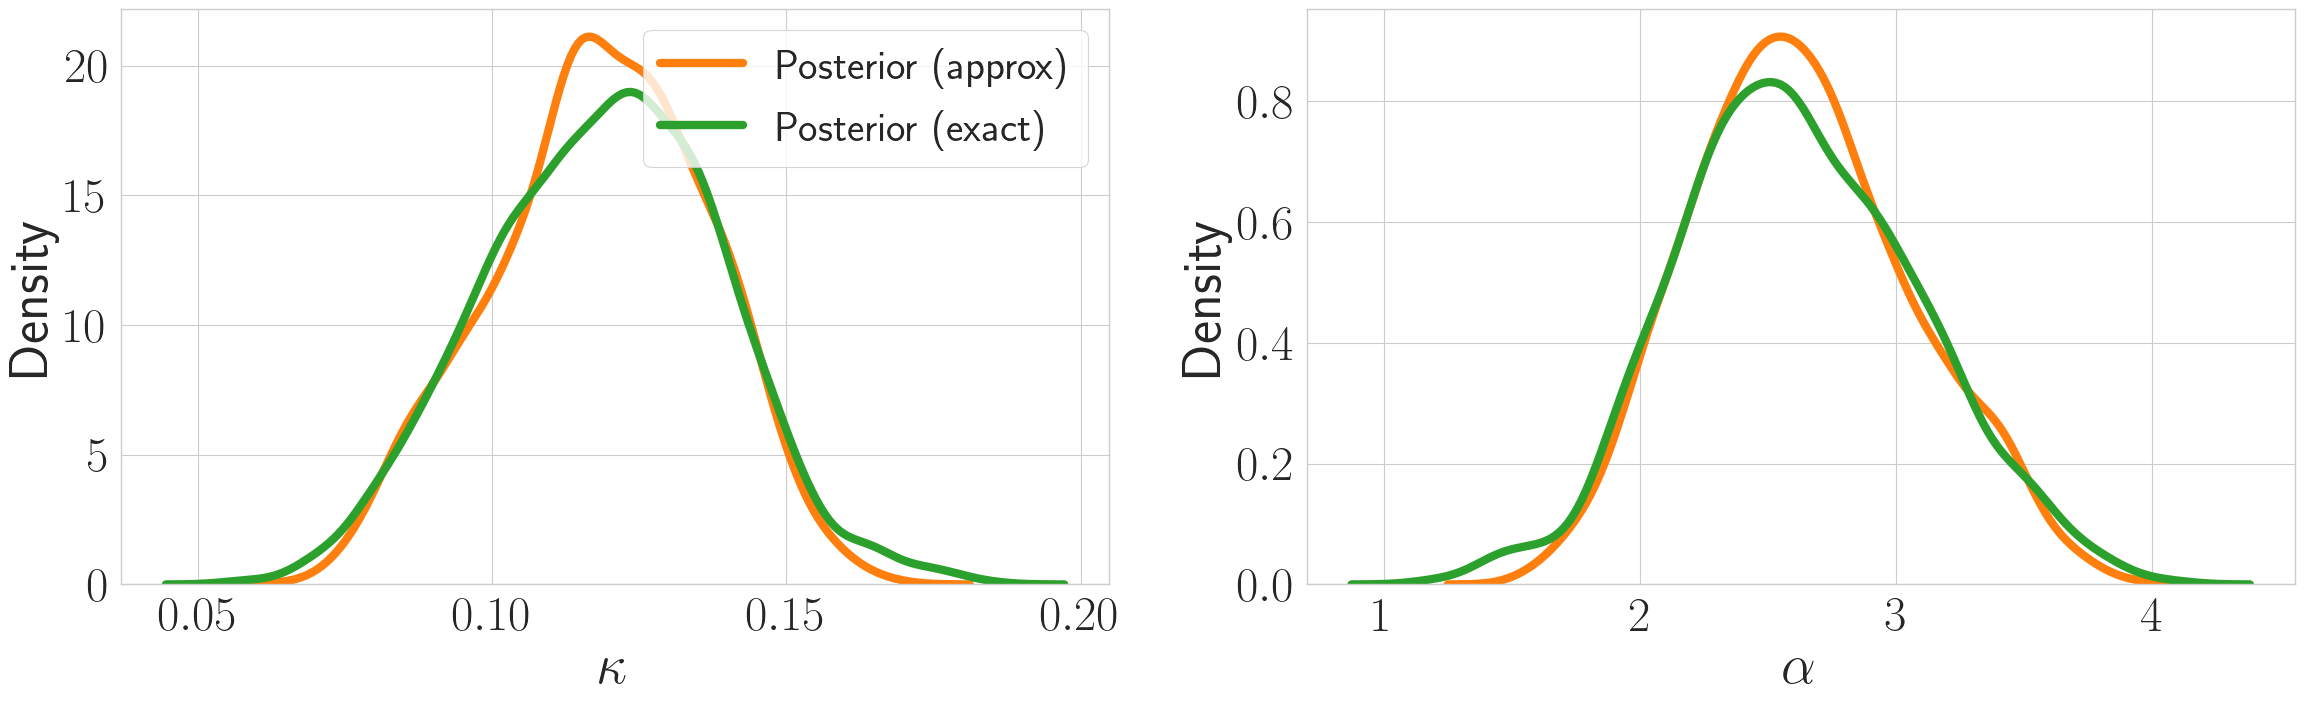

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=param_dim, figsize = (24,8))
lw = 6
lw_sm = 4
fs = 40
fs_sm = 30

tag_i = ['approx', 'exact']
color_i = ['tab:orange', 'tab:green']

for i in range(2):

    plot_samples = np.exp(data[i+1]['s'])

    # get mean 
    plot_samples_mean = [np.mean(plot_samples[:, i]) for i in range(param_dim)]
    plot_samples_std = [np.std(plot_samples[:, i]) for i in range(param_dim)]
    
    print(plot_samples_mean, plot_samples_std)

    idx = 0
    for col in range(param_dim):
        # prior
#         if i == 0:
#             sns.distplot(np.exp(prior_samples[:, idx]), hist=False, ax=axs[col], \
#                      label='Prior', \
#                      kde_kws={"lw": lw})
        # posterior
        ax = sns.distplot(plot_samples[:, idx], hist=False, bins = 25, ax=axs[col],  \
                     label='Posterior ({})'.format(tag_i[i]), \
                     kde_kws={"lw": lw}, color = color_i[i])

#         xlims = axs[col].get_xlim()
#         ylims = axs[col].get_ylim()
#         dx_lims = xlims[1] - xlims[0]
#         dy_lims = ylims[1] - ylims[0]

#         vline_x = plot_samples_mean[idx]
#         #vline_x = plot_samples_mean_ln_exp[idx]

#         text_y = ylims[0] + 0.5 * (ylims[1] - ylims[0])
#         text_x = vline_x + 0.13 * dx_lims
#         text_ha_align = 'left'

#         arrow_width = 0.005 * dy_lims
#         arrow_head_width = 5 * arrow_width
#         arrow_head_length = 0.01 * dx_lims

#         arrow_dx = vline_x - text_x + 0.01 * dx_lims

#         #if xlims[1] - text_x < 0.4 * dx_lims:
#         #    text_x = vline_x - 0.2 * dx_lims
#         #    text_ha_align = 'right'
#         #    arrow_dx = vline_x - text_x - 1 * arrow_width


#         axs[col].axvline(x=vline_x, color='dimgray', lw = lw_sm)#, zorder = 10)
#         axs[col].text(text_x, text_y, \
#                            r'posterior mean(' + titles_real[idx] + r')' + '\n' + r'= ' + '%6.4f' % (vline_x), \
#                            color = 'dimgray', va = 'center', ha = text_ha_align, fontsize = fs, zorder = 10)


#         axs[col].arrow(text_x, text_y, dx = arrow_dx, dy = 0, \
#                        color = 'r', lw = lw, \
#                        width = arrow_width, \
#                        head_width = arrow_head_width, head_length = arrow_head_length, zorder = 10)


        axs[col].set_xlabel(titles_real[idx], fontsize = fs)
        axs[col].set_ylabel(r"Density", fontsize = fs)
        if col == 0:
            axs[col].legend(fancybox=True, fontsize = fs_sm, loc = 'upper right')
        idx += 1

fig.tight_layout()
if savefig:
    plt.savefig(sfpath + 'compare_posterior_real_burn.pdf')